# Workflow for integration st, msi neg, msi pos and lmd

In [1]:
import sys
sys.path.append('../..')

import os
from os.path import join, exists


from miit.reg_graph import RegGraph
from miit.spatial_data.section import Section
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from pyimzml.ImzMLParser import ImzMLParser
import tqdm

from miit.reg_graph import RegGraph
from miit.spatial_data.section import Section, register_to_ref_image
from miit.spatial_data.image import Annotation, GeoJson, Image
from miit.spatial_data.molecular_imaging.scils_export_imzml import get_metabolite_intensities_targeted, msi_default_accumulate_spot_weighted_mean
from miit.integration.integration import (
    get_mappings, 
    map_mapping_index_to_table_index, 
    accumulate_counts,
    integrate_annotations
)

In [2]:
root_dir = '/mnt/scratch/maximilw/data/registered_spatial_multiomics_samples/'
os.listdir(root_dir)

['004_02',
 '002_02',
 '003_03',
 '047_03',
 '046_04',
 '002_04',
 '046_01',
 '047_01',
 '003_01',
 '003_04',
 '048_03',
 '046_03',
 '048_04',
 '002_01',
 '001_01',
 '001_04',
 '002_03',
 '045_01',
 '001_03',
 '004_03',
 '047_04',
 '045_04',
 '047_02',
 '004_01',
 '048_02',
 '004_04',
 '046_02',
 '003_02',
 '048_01',
 '045_03',
 '001_02',
 '045_02']

In [3]:
def load_sections(core_name):
    sections = {}
    dir_ = join(root_dir, core_name, 'sections')
    for section_id in os.listdir(dir_):
        section = Section.load(join(dir_, section_id))
        sections[section_id] = section
    return sections

def get_core_names():
    return os.listdir(root_dir)

In [10]:
core_name = '001_01'

sections = load_sections(core_name)

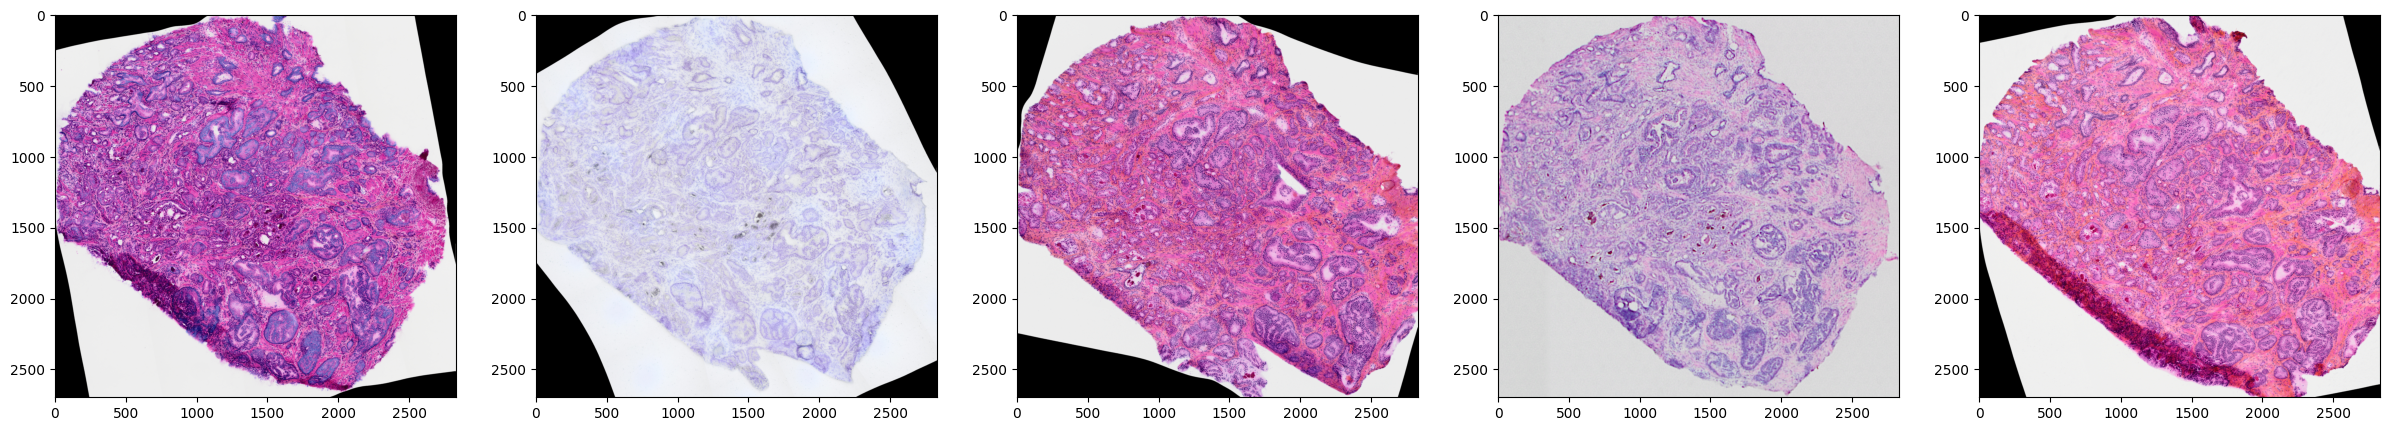

In [6]:
fig, axs = plt.subplots(1, len(sections), figsize=(len(sections)*6, 6))
for idx, key in enumerate(sections):
    axs[idx].imshow(sections[key].image.data)

### Integrate msi pos

In [4]:
with open('pos_ion_labels.txt') as f:
    msi_pos_labels = [x.strip() for x in f.readlines()]

msi_pos_dir= 'msi_pos'

In [170]:
for core_name in tqdm.tqdm(get_core_names()):
    sections = load_sections(core_name)
    st_section = sections['2']
    msi_section = sections['6']
    st_data = st_section.molecular_data
    msi_data = msi_section.molecular_data
    mappings, spots_background, unique_vals = get_mappings(st_data.ref_mat.data, msi_data.ref_mat.data, st_data.background, msi_data.background)
    msi_pixel_idxs = msi_data.set_map_to_msi_pixel_idxs(unique_vals)
    msi_mappings = msi_data.mappings_map_to_msi_pixel_idxs(mappings)
    msi = ImzMLParser(msi_data.config['imzml'])
    metabolites_df = get_metabolite_intensities_targeted(msi, msi_pixel_idxs, msi_pos_labels)
    accumulated_df = accumulate_counts(msi_mappings, metabolites_df, spots_background, msi_default_accumulate_spot_weighted_mean)
    integrated_df = map_mapping_index_to_table_index(accumulated_df, st_data)
    target_dir = join(root_dir, core_name, msi_pos_dir)
    if not exists(target_dir):
        os.mkdir(target_dir)
    integrated_df.to_csv(f'{target_dir}/integrated_data.csv')

100%|██████████| 32/32 [00:24<00:00,  1.33it/s]


In [171]:
# Now integrate annotations
for core_name in tqdm.tqdm(get_core_names()):
    sections = load_sections(core_name)
    st_section = sections['2']
    msi_section = sections['6']
    print('Classes in annotations: ', msi_section.annotations[0].labels)
    integrated_annotations_df = integrate_annotations(st_section.molecular_data, msi_section.annotations[0])
    target_dir = join(root_dir, core_name, msi_pos_dir)
    if not exists(target_dir):
        os.mkdir(target_dir)
    integrated_annotations_df.to_csv(f'{target_dir}/integrated_annotations.csv')

  0%|          | 0/32 [00:00<?, ?it/s]

Classes in annotations:  ['Vessel', 'ISUP3', 'Lymphocytes', 'Stone', 'ISUP1', 'Normal Glands', 'Tissue', 'Lymphocyte_enriched_stroma']


100%|██████████| 32/32 [00:29<00:00,  1.10it/s]


## MSI Neg

In [5]:

msi_neg_dir= 'msi_neg'

msi_neg_df = pd.read_csv('IdentifiedPeaks.csv', sep=';')
# msi_neg_df.Name.to_list()
msi_neg_labels = msi_neg_df.Name.to_list()

In [ ]:
for core_name in tqdm.tqdm(get_core_names()):
    sections = load_sections(core_name)
    st_section = sections['2']
    msi_section = sections['7']
    st_data = st_section.molecular_data
    msi_data = msi_section.molecular_data
    mappings, spots_background, unique_vals = get_mappings(st_data.ref_mat.data, msi_data.ref_mat.data, st_data.background, msi_data.background)
    msi_pixel_idxs = msi_data.set_map_to_msi_pixel_idxs(unique_vals)
    msi_mappings = msi_data.mappings_map_to_msi_pixel_idxs(mappings)
    msi = ImzMLParser(msi_data.config['imzml'])
    metabolites_df = get_metabolite_intensities_targeted(msi, msi_pixel_idxs, msi_neg_labels)
    accumulated_df = accumulate_counts(msi_mappings, metabolites_df, spots_background, msi_default_accumulate_spot_weighted_mean)
    integrated_df = map_mapping_index_to_table_index(accumulated_df, st_data)
    target_dir = join(root_dir, core_name, msi_neg_dir)
    if not exists(target_dir):
        os.mkdir(target_dir)
    integrated_df.to_csv(f'{target_dir}/integrated_data.csv')

100%|██████████| 32/32 [00:17<00:00,  1.88it/s]


In [ ]:
# Now integrate annotations
for core_name in tqdm.tqdm(get_core_names()):
    sections = load_sections(core_name)
    st_section = sections['2']
    msi_section = sections['7']
    print('Classes in annotations: ', msi_section.annotations[0].labels)
    integrated_annotations_df = integrate_annotations(st_section.molecular_data, msi_section.annotations[0])
    target_dir = join(root_dir, core_name, msi_neg_dir)
    if not exists(target_dir):
        os.mkdir(target_dir)
    integrated_annotations_df.to_csv(f'{target_dir}/integrated_annotations.csv')

  0%|          | 0/32 [00:00<?, ?it/s]

Classes in annotations:  ['Empty', 'Stroma', 'Normal Glands', 'ISUP1', 'ISUP2', 'ISUP3', 'ISUP4', 'ISUP5', 'ISUPY', 'ISUPX', 'Lymphocytes', 'Lymphocyte_enriched_stroma', 'PNI', 'PIN', 'Tissue', 'Vessel', 'Stone', 'Uncertain', 'Lumen']


100%|██████████| 32/32 [00:26<00:00,  1.20it/s]


## LMD Integration

Integration as follows:
Match LMD data as annotations with spatial transcriptomics spots. Then write down for each spot what percentage is covered by which annotations.

In [6]:
lmd_dir_name = 'lmd'

In [ ]:
all_labels = []
for core_name in tqdm.tqdm(get_core_names()):
    if core_name != '002_03':
        continue
    sections = load_sections(core_name)
    st_section = sections['2']
    lmd_section = sections['4']
    print('Classes in annotations: ', lmd_section.annotations[0].labels)
    lmd_anns = lmd_section.annotations[0]
    integrated_annotations_df = integrate_annotations(st_section.molecular_data, lmd_anns)
    all_labels += lmd_section.annotations[0].labels
    if 'Tissue' in integrated_annotations_df.columns:
        integrated_annotations_df.drop('Tissue', axis=1, inplace=True)
    target_dir = join(root_dir, core_name, lmd_dir_name)
    if not exists(target_dir):
        os.mkdir(target_dir)
    integrated_annotations_df.to_csv(f'{target_dir}/integrated_annotations.csv')

  0%|          | 0/32 [00:00<?, ?it/s]

Classes in annotations:  ['002_LD_s03_A_adjusted', '002_LD_s03_B_adjusted', '002_LD_s03_D1_adjusted', '002_LD_s03_D2_adjusted', '002_LD_s03_C_adjusted', '002_LD_s03_E_adjusted', '002_LD_s03_F_adjusted']


100%|██████████| 32/32 [00:26<00:00,  1.23it/s]


In [12]:
# all_labels = {}
all_labels = []
for core_name in tqdm.tqdm(get_core_names()):
    sections = load_sections(core_name)
    lmd_section = sections['4']
    # print('Classes in annotations: ', lmd_section.annotations[0].labels)
    # integrated_annotations_df = integrate_annotations(st_section.molecular_data, lmd_section.annotations[0])
    # all_labels[core_name] = lmd_section.annotations[0].labels
    all_labels += lmd_section.annotations[0].labels
    # if 'Tissue' in integrated_annotations_df.columns:
    #     integrated_annotations_df.drop('Tissue', axis=1, inplace=True)
    # target_dir = join(root_dir, core_name, lmd_dir_name)
    # if not exists(target_dir):
    #     os.mkdir(target_dir)
    # integrated_annotations_df.to_csv(f'{target_dir}/integrated_annotations.csv')

100%|██████████| 32/32 [04:23<00:00,  8.25s/it]


In [60]:
# TODO: Section 4_2 in 048_04
core_name = '048_04'
sections = load_sections(core_name)
st_section = sections['2']
lmd_section1 = sections['4']
lmd_section2 = sections['4_2']
print('Classes in annotations 1: ', lmd_section1.annotations[0].labels)
print('Classes in annotations 2: ', lmd_section2.annotations[0].labels)
integrated_annotations1_df = integrate_annotations(st_section.molecular_data, lmd_section1.annotations[0])
integrated_annotations2_df = integrate_annotations(st_section.molecular_data, lmd_section2.annotations[0])

Classes in annotations 1:  ['E', 'Tissue', 'Tissue', '048_LD_s04_B', '048_LD_s04_A', '048_LD_s04_C', '048_LD_s04_D']
Classes in annotations 2:  ['E', 'Tissue', 'Tissue', '048_LD_s04_B', '048_LD_s04_A', '048_LD_s04_C', '048_LD_s04_D']


In [81]:
cols1 = ['E']
cols2 = ['048_LD_s04_B', '048_LD_s04_A', '048_LD_s04_D', '048_LD_s04_D']

In [82]:
integrated_annotations_df = pd.concat([integrated_annotations1_df[cols1], integrated_annotations2_df[cols2]], axis=1)
target_dir = join(root_dir, core_name, lmd_dir_name)
if not exists(target_dir):
    os.mkdir(target_dir)
integrated_annotations_df.to_csv(f'{target_dir}/integrated_annotations.csv')


## Now make big dfs

In [7]:
import glob

In [8]:
meta_df = pd.read_csv('metadata_big_final.csv')
meta_df.head(3)

,Sample ID,adjusted_core_type,Round nr,Square (a-d) on slide,type,recurrence,patient_id,core_name,st_identifier_y,correct_st_identifier
0,PS D008.c2,c,47,a,Cancer,control,PS_D008,047_01,V10A20_007_1,V10A20_007_A
1,PS D004.c6,c,47,b,Cancer,recurrence,PS_D004,047_02,V10A20_007_2,V10A20_007_B
2,PS C003.c6,c,47,c,Field effect,recurrence,PS_C003,047_03,V10A20_007_3,V10A20_007_C


In [9]:
# msi pos files
def get_core_name(path):
    return path.rsplit('/', maxsplit=3)[1]

def get_global_st_identifier(core_name):
    return meta_df[meta_df.core_name == core_name]['correct_st_identifier'].iloc[0]

msi_pos_files = glob.glob(join(root_dir, '*', msi_pos_dir, 'integrated_data.csv'))
all_dfs = []
for msi_pos_file in msi_pos_files:
    core_name = get_core_name(msi_pos_file)
    global_st_identifier = get_global_st_identifier(core_name)
    msi_pos_file, core_name, global_st_identifier
    small_df = pd.read_csv(msi_pos_file, index_col=0)
    small_df.rename(index={x: f'{global_st_identifier}_{x}' for x in small_df.index}, inplace=True)
    all_dfs.append(small_df)
df = pd.concat(all_dfs)
df.fillna(0, inplace=True)
df.to_csv('/mnt/scratch/maximilw/data/global_integration_files/integrated_msi_pos_data.csv')
df.shape

(30708, 31)

In [10]:
msi_pos_files = glob.glob(join(root_dir, '*', msi_pos_dir, 'integrated_annotations.csv'))
all_dfs = []
for msi_pos_file in msi_pos_files:
    core_name = get_core_name(msi_pos_file)
    global_st_identifier = get_global_st_identifier(core_name)
    msi_pos_file, core_name, global_st_identifier
    small_df = pd.read_csv(msi_pos_file, index_col=0)
    if 'Lymphocyte_enriched_stroma.1' in small_df.columns:
        small_df['Lymphocyte_enriched_stroma'] += small_df['Lymphocyte_enriched_stroma.1']
        small_df.drop('Lymphocyte_enriched_stroma.1', axis=1, inplace=True)
    if 'Normal Glands.1' in small_df.columns:
        small_df['Normal Glands'] += small_df['Normal Glands.1']
        small_df.drop('Normal Glands.1', axis=1, inplace=True)
    if 'ISUP2.1' in small_df.columns:
        small_df['ISUP2'] += small_df['ISUP2.1']
        small_df.drop('ISUP2.1', axis=1, inplace=True)
    small_df.rename(index={x: f'{global_st_identifier}_{x}' for x in small_df.index}, inplace=True)
    all_dfs.append(small_df)
df = pd.concat(all_dfs)
df.fillna(0, inplace=True)
df.to_csv('/mnt/scratch/maximilw/data/global_integration_files/integrated_msi_pos_annotations.csv')
df.shape

(159744, 16)

In [11]:
msi_neg_files = glob.glob(join(root_dir, '*', msi_neg_dir, 'integrated_data.csv'))
all_dfs = []
for msi_neg_file in msi_neg_files:
    core_name = get_core_name(msi_neg_file)
    global_st_identifier = get_global_st_identifier(core_name)
    msi_neg_file, core_name, global_st_identifier
    small_df = pd.read_csv(msi_neg_file, index_col=0)
    small_df.rename(index={x: f'{global_st_identifier}_{x}' for x in small_df.index}, inplace=True)
    all_dfs.append(small_df)
df = pd.concat(all_dfs)
df.fillna(0, inplace=True)
df.to_csv('/mnt/scratch/maximilw/data/global_integration_files/integrated_msi_neg_data.csv')
df.shape

(30708, 40)

In [12]:
msi_neg_files = glob.glob(join(root_dir, '*', msi_neg_dir, 'integrated_annotations.csv'))
all_dfs = []
for msi_neg_file in msi_neg_files:
    core_name = get_core_name(msi_neg_file)
    global_st_identifier = get_global_st_identifier(core_name)
    msi_neg_file, core_name, global_st_identifier
    small_df = pd.read_csv(msi_neg_file, index_col=0)
    small_df.rename(index={x: f'{global_st_identifier}_{x}' for x in small_df.index}, inplace=True)
    all_dfs.append(small_df)
df = pd.concat(all_dfs)
df.fillna(0, inplace=True)
df.to_csv('/mnt/scratch/maximilw/data/global_integration_files/integrated_msi_neg_annotations.csv')
df.shape

(159744, 19)

## LMD assign

In [118]:
lmd_files = glob.glob(join(root_dir, '*', lmd_dir_name, 'integrated_annotations.csv'))
all_dfs = []
for lmd_file in lmd_files:
    core_name = get_core_name(lmd_file)
    global_st_identifier = get_global_st_identifier(core_name)
    small_df = pd.read_csv(lmd_file, index_col=0)
    small_df.rename(index={x: f'{global_st_identifier}_{x}' for x in small_df.index}, inplace=True)
    all_dfs.append(small_df)
df = pd.concat(all_dfs)
df.fillna(0, inplace=True)
df.to_csv('/mnt/scratch/maximilw/data/global_integration_files/integrated_lmd_annotations.csv')
df.shape

(159744, 199)

In [120]:
lmd_assignments = pd.read_csv('lmd_assignments.csv')
lmd_assignments

,sammenligne,decoded sample ID,recurrent,tissue type category
0,1,047_LD_s01_E,control,stroma
1,2,046_LD_s02_A,control,stroma
2,3,003_LD_s01_C,recurrence,stroma
3,4,045_LD_s01_D,recurrence,stroma
4,5,001_LD_s02_A,recurrence,stroma
...,...,...,...,...
109,110,002_LD_s04_B,recurrence,LES
110,111,003_LD_s04_A,control,stone
111,112,048_LD_s02_C,recurrence,stone
112,113,002_LD_s01_A,control,PIN


In [155]:
qupath_ann_2_col_name = {}
rev_dict = {}
for idx, row in lmd_assignments.iterrows():
    key = row['decoded sample ID']
    rec = row['recurrent']
    rec = 'cnt' if rec == 'control' else 'rec'
    ttc = row['tissue type category']
    ttc = ttc.split()[0]
    if ttc == 'lymphocytes':
        ttc = 'Lym'
    no = row['sammenligne']
    col_name = f'{ttc}{no}_{rec}'
    qupath_ann_2_col_name[key] = col_name
    rev_dict[col_name] = key

In [156]:
# qupath_ann_2_col_name

In [137]:
a = """stroma1_cnt	stroma2_cnt	stroma4_rec	stroma5_rec	stroma6_rec	stroma8_rec	stroma9_cnt	stroma10_cnt	stroma11_rec	stroma12_cnt	stroma13_rec	stroma14_rec	stroma15_rec	stroma16_cnt	stroma17_cnt	stroma18_rec	stroma20_cnt	stroma21_cnt	stroma22_rec	stroma23_rec	stroma24_cnt	stroma25_rec	stroma26_cnt	stroma27_cnt	stroma28_rec	NCE29_rec	NCE30_rec	NCE33_rec	NCE35_cnt	NCE36_cnt	NCE38_rec	NCE39_rec	NCE40_rec	NCE41_cnt	NCE43_rec	NCE45_rec	NCE46_rec	NCE47_rec	NCE48_rec	NCE49_rec	NCE50_rec	NCE51_rec	NCE52_rec	NCE53_cnt	NCE54_cnt	NCE55_rec	NCE56_rec	NCE57_cnt	NCE58_cnt	LG59_cnt	LG60_cnt	LG61_cnt	LG62_cnt	LG63_rec	LG64_cnt	LG65_cnt	LG66_rec	LG67_rec	LG68_rec	LG69_rec	LG71_rec	LG73_cnt	LG74_rec	LG76_cnt	HG77_rec	HG78_rec	HG79_rec	HG80_rec	HG81_rec	HG82_rec	HG83_rec	HG84_rec	HG85_rec	HG86_rec	HG88_rec	HG89_cnt	HG90_rec	HG91_cnt	HG92_rec	HG93_rec	HG94_rec	Lym95_rec	Lym96_rec	Lym97_rec	Lym98_rec	Lym99_rec	Lym100_rec	Lym101_rec	Lym102_rec	Lym103_rec	LES105_rec	LES106_rec	LES107_rec	LES108_rec	LES109_rec	LES110_rec	PIN113_cnt	PNI114_rec
""".split()
for b in a:
    if b not in qupath_ann_2_col_name.values():
        print(b)

In [157]:
count_dict = {x: 0 for x in a}
# count_dict

In [158]:
len(a)

98

In [159]:
counter = 0
for col in df.columns:
    col = col.replace('_adjusted', '')
    col = col.replace('_smp', '')
    if col.endswith('_ny'):
        col = col.replace('_ny', '')
    if col in qupath_ann_2_col_name:
        val = qupath_ann_2_col_name[col]
        if val not in count_dict:
            print('Col not in count dict: ', col)
        else:
            count_dict[val] += 1
        counter +=1
    else:
        print(col)
        # print(qupath_ann_2_col_name[col])
counter
    

004_LD_s02_E
004_LD_s02_D
Col not in count dict:  002_LD_s02_B
002_LD_s02_C
003_LD_s03_D1
003_LD_s03_D2
047_LD_s03_C
047_LD_s03_A1
047_LD_s03_A2
047_LD_s03_A3A4
046_LD_s04_A1
046_LD_s04_A2
046_LD_s04_D
046_LD_s04_A3
046_LD_s04_A4
046_LD_s04_A5
002_LD_s04_D2
002_LD_s04_D1
Col not in count dict:  002_LD_s04_G
046_LD_s01_D
046_LD_s01_C2
046_LD_s01_C1
047_LD_s01_F
Col not in count dict:  003_LD_s01_C
Col not in count dict:  003_LD_s04_A
003_LD_s04_B3
003_LD_s04_B1
003_LD_s04_B2
003_LD_s04_F1
003_LD_s04_F2
003_LD_s04_C2
003_LD_s04_E
003_LD_s04_C1
048_LD_s03_A1
048_LD_s03_E
048_LD_s03_A2
046_LD_s03_C2
046_LD_s03_C1
046_LD_s03_D1
046_LD_s03_D2
E
Col not in count dict:  048_LD_s04_B
048_LD_s04_D.1
002_LD_s01_E
002_LD_s01_D
001_LD_s01_F
001_LD_s01_C1
001_LD_s01_C2
Col not in count dict:  001_LD_s01_D
001_LD_s01_E
001_LD_s04_B1
001_LD_s04_B2
001_LD_s04_B3
001_LD_s04_C
Col not in count dict:  002_LD_s03_A
002_LD_s03_D1
002_LD_s03_D2
002_LD_s03_E
045_LD_s01_E
045_LD_s01_B
045_LD_s01_A1
045_LD_s01_

93

In [161]:
rev_dict['stroma6_rec']

'002_LD_s03_D'

In [164]:
for c in df.columns:
    if c.startswith('002'):
        print(c)

002_LD_s02_A_adjusted
002_LD_s02_B_adjusted
002_LD_s02_C_adjusted
002_LD_s04_A
002_LD_s04_B_adjusted
002_LD_s04_C_adjusted
002_LD_s04_D2_adjusted
002_LD_s04_D1
002_LD_s04_E_adjusted
002_LD_s04_F_adjusted
002_LD_s04_G_adjusted
002_LD_s01_A
002_LD_s01_E
002_LD_s01_B
002_LD_s01_D
002_LD_s01_C_adjusted
002_LD_s03_A_adjusted
002_LD_s03_B_adjusted
002_LD_s03_D1_adjusted
002_LD_s03_D2_adjusted
002_LD_s03_C_adjusted
002_LD_s03_E_adjusted
002_LD_s03_F_adjusted


In [160]:
for key in count_dict:
    if count_dict[key] != 1:
        print(key)

stroma6_rec
stroma12_cnt
stroma13_rec
stroma14_rec
stroma16_cnt
stroma23_rec
stroma24_cnt
stroma27_cnt
stroma28_rec
NCE30_rec
NCE48_rec
NCE49_rec
NCE58_cnt
LG66_rec
LG69_rec
HG81_rec
HG84_rec
Lym95_rec
Lym99_rec
Lym100_rec


### Now match tissue types and reduce dataset

In [25]:
msi_pos_ann_df = pd.read_csv('/mnt/scratch/maximilw/data/global_integration_files/integrated_msi_pos_annotations.csv', index_col=0)
print('Number of points before only using tissue: ', msi_pos_ann_df.shape[0])
msi_pos_ann_df = msi_pos_ann_df[msi_pos_ann_df.Tissue > 0.8]
msi_pos_ann_df.drop(['Tissue'], axis=1, inplace=True)
new_names = {
    'Normal Glands': 'Non-cancer glands',
    'Lymphocyte_enriched_stroma': 'Lymphocyte-enriched stroma',
}
msi_pos_ann_df = msi_pos_ann_df.rename(columns=new_names)
msi_pos_ann_df = msi_pos_ann_df.idxmax(1)
msi_pos_ann_df.to_csv('/mnt/scratch/maximilw/data/global_integration_files/msi_pos_annotations_reduced.csv')

Number of points before only using tissue:  159744


In [26]:
msi_pos_df = pd.read_csv('/mnt/scratch/maximilw/data/global_integration_files/integrated_msi_pos_data.csv', index_col=0)
print('Number of points before matching: ', msi_pos_df.shape[0])
intersecting_msi_pos_idxs = msi_pos_df.index.intersection(msi_pos_ann_df.index)
msi_pos_df = msi_pos_df.loc[intersecting_msi_pos_idxs]
print('Number of points after matching: ', msi_pos_df.shape[0])
msi_pos_df.to_csv('/mnt/scratch/maximilw/data/global_integration_files/msi_pos_data_reduced.csv')

Number of points before matching:  30708
Number of points after matching:  20736


In [27]:
msi_neg_ann_df = pd.read_csv('/mnt/scratch/maximilw/data/global_integration_files/integrated_msi_neg_annotations.csv', index_col=0)
print('Number of points before only using tissue: ', msi_neg_ann_df.shape[0])
msi_neg_ann_df = msi_neg_ann_df[msi_neg_ann_df.Tissue > 0.8]
msi_neg_ann_df.drop(['Tissue', 'Empty'], axis=1, inplace=True)
new_names = {
    'Normal Glands': 'Non-cancer glands',
    'Lymphocyte_enriched_stroma': 'Lymphocyte-enriched stroma',
}
msi_neg_ann_df = msi_neg_ann_df.rename(columns=new_names)
msi_neg_ann_df = msi_neg_ann_df.idxmax(1)
print('Number of points before only using tissue: ', msi_neg_ann_df.shape[0])
msi_neg_ann_df.to_csv('/mnt/scratch/maximilw/data/global_integration_files/msi_neg_annotations_reduced.csv')

Number of points before only using tissue:  159744
Number of points before only using tissue:  21191


In [28]:
msi_neg_df = pd.read_csv('/mnt/scratch/maximilw/data/global_integration_files/integrated_msi_neg_data.csv', index_col=0)
print('Number of points before matching: ', msi_neg_df.shape[0])
intersecting_msi_neg_idxs = msi_neg_df.index.intersection(msi_neg_ann_df.index)
msi_neg_df = msi_neg_df.loc[intersecting_msi_neg_idxs]
print('Number of points after matching: ', msi_neg_df.shape[0])
msi_neg_df.to_csv('/mnt/scratch/maximilw/data/global_integration_files/msi_neg_data_reduced.csv')

Number of points before matching:  30708
Number of points after matching:  21191


In [22]:
lmd_df = pd.read_csv('/mnt/scratch/maximilw/data/global_integration_files/integrated_lmd_annotations.csv', index_col=0)
lmd_df = lmd_df.idxmax(1)
lmd_df.to_csv('/mnt/scratch/maximilw/data/global_integration_files/lmd_series.csv')

In [29]:
# Now match against st data
fpath = '/mnt/work/Maria/st_data_des21/raw_umis_reduced_norm21_07122021.feather'
spot_annotations_df = pd.read_feather(fpath)
spot_annotations_df.set_index('index', inplace=True)
spot_annotations_df.shape

(19854, 2463)

In [30]:
gsea_path = '../gsea_data_SpTr_Morten_jun2023.txt'
gsea_df = pd.read_csv(gsea_path, sep='\t', index_col=0)
gsea_df

,dist_to_cancer,PRECAST_pos,PRECAST_neg,PRECAST_pos_gland,PRECAST_pos_stroma,PRECAST_neg_gland,PRECAST_neg_stroma,Citsper,Stroma_pos,Stroma_neg,...,PRECAST_gland,PRECAST_stroma,lowgrade_gland,lowgrade_stroma,Chem_pos,Chem_neg,Chem_sk,chem2_pos,chem2_neg,chem2
index,,,,,,,,,,,,,,,,,,,,,
V10A20_007_A_AAACGAGACGGTTGAT-1,1.133360,-183.170883,269.656700,-189.967105,-164.930761,268.986468,163.098669,280.222771,-250.584675,7.207207,...,-247.253624,-164.291297,46.690291,0.328546,-306.164667,421.817058,-352.482936,-242.686444,-359.522830,6.877126
V10A20_007_A_AAAGGGATGTAGCAAG-1,0.000000,-295.002074,328.626800,198.601974,-402.710380,375.843295,156.442981,350.568366,-506.053102,185.793486,...,-217.852532,-316.754469,41.819013,81.208726,72.817542,478.728883,-148.074353,154.511743,-3.290827,91.843775
V10A20_007_A_AAATACCTATAAGCAT-1,0.000000,-468.564220,203.119232,-184.758772,-500.828500,319.998422,-350.487169,289.176205,-602.627597,115.384615,...,-282.803206,-203.689642,66.467471,-6.035976,-660.322714,230.892048,-488.337638,-619.695097,-691.484986,-76.324549
V10A20_007_A_AAATCGTGTACCACAA-1,0.000000,198.897415,366.955826,163.788377,192.646073,345.543851,416.220667,300.614513,62.697758,-50.589051,...,-205.461250,-19.869654,-5.226783,107.241302,694.249069,777.915122,104.653845,762.257932,645.413410,178.900117
V10A20_007_A_AAATGGTCAATGTGCC-1,0.000000,82.503802,305.570936,5.482456,94.409595,294.137373,258.748456,362.937515,139.427707,110.810811,...,-211.732368,-28.854882,15.529954,75.123918,573.438146,584.105892,109.846897,649.773383,513.780337,167.581173
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V19S23_108_D_TTGTAAGGCCAGTTGG-1,0.000000,-230.557860,-348.975637,311.129386,-320.333767,-396.141555,-260.806916,-238.958088,-619.892695,90.575191,...,372.760498,-117.495401,144.238349,178.331576,-22.111893,-409.147095,150.605418,-66.749073,-192.102016,40.522277
V19S23_108_D_TTGTAATCCGTACTCG-1,0.000000,-208.990046,-280.346376,-59.895833,-173.294670,-254.842782,-441.882805,-214.484053,-414.018434,34.788635,...,168.279628,41.423724,119.947650,176.195129,-13.009700,-334.157396,126.029181,-60.980635,-166.186754,33.160567
V19S23_108_D_TTGTCGTTCAGTTACC-1,1.989573,191.137840,67.921742,-71.820175,262.950251,99.775121,-31.014135,-82.667413,433.897372,-30.076230,...,-92.086620,181.996457,183.560377,266.637106,447.363582,222.342398,179.149310,439.637412,356.232003,109.818491


In [31]:
glob_id_2_core_dict = {}
for sub_dir in os.listdir(root_dir):
    # print(sub_dir)
    core_name = sub_dir.split('.')[0]
    # config_path = f'../configs/cores_hr/{core_name}.json'
    st_identifier = get_global_st_identifier(core_name)
    spot_idxs = [x for x in spot_annotations_df.index if x.startswith(st_identifier)]
    for spot_idx in spot_idxs:
        glob_id_2_core_dict[spot_idx] = core_name
    
c2gsi = pd.DataFrame(glob_id_2_core_dict, index=[0]).transpose().rename(columns={0: 'core_name'})
spot_annotations_df['core_name'] = c2gsi.core_name
spot_annotations_df['st_identifier'] = [x.rsplit('_', maxsplit=1)[0] for x in spot_annotations_df.index]
spot_annotations_df['recurrence'] = spot_annotations_df.recurrence_vector.apply(lambda x: 'recurrence' if x == 1 else 'control')
spot_annotations_df['Citsper'] = gsea_df.Citsper

In [32]:
intersecting_idxs_st_msi_neg = spot_annotations_df.index.intersection(msi_neg_df.index)
msi_neg_df = msi_neg_df.loc[intersecting_idxs_st_msi_neg]
msi_neg_ann_df = msi_neg_ann_df.loc[intersecting_idxs_st_msi_neg]
msi_neg_df.to_csv('/mnt/scratch/maximilw/data/global_integration_files/st_msi_neg.csv')
msi_neg_ann_df.to_csv('/mnt/scratch/maximilw/data/global_integration_files/st_msi_neg_ann.csv')

In [33]:
intersecting_idxs_st_msi_pos = spot_annotations_df.index.intersection(msi_pos_df.index)
msi_pos_df = msi_pos_df.loc[intersecting_idxs_st_msi_pos]
msi_pos_ann_df = msi_pos_ann_df.loc[intersecting_idxs_st_msi_pos]
msi_pos_df.to_csv('/mnt/scratch/maximilw/data/global_integration_files/st_msi_pos.csv')
msi_pos_ann_df.to_csv('/mnt/scratch/maximilw/data/global_integration_files/st_msi_pos_ann.csv')

In [34]:
merging_msi_neg_df = msi_neg_df.rename(columns={x:'met_' + x for x in msi_neg_df.columns})
merging_msi_neg_df = pd.concat([merging_msi_neg_df, spot_annotations_df.loc[intersecting_idxs_st_msi_neg]], axis=1)
merging_msi_neg_df['msi_hist'] = msi_neg_ann_df
merging_msi_neg_df.to_csv('/mnt/scratch/maximilw/data/global_integration_files/merged_st_msi_neg.csv')

In [207]:
merging_msi_neg_df

,met_Taurine,met_Aspartate,met_PEA,met_Glutamine,met_Glutamate,met_Urate,met_NAA,met_Zinc,met_Ascorbate,met_Citrate,...,MT-ND4L - ENSG00000212907,MT-ND4 - ENSG00000198886,MT-ND5 - ENSG00000198786,MT-CYB - ENSG00000198727,AC011043.1 - ENSG00000276256,core_name,st_identifier,recurrence,Citsper,msi_hist
V10A20_007_A_AAACGAGACGGTTGAT-1,11.815958,17.866579,3.524791,5.682940,17.919615,1.216555,1.608106,4.236659,6.042164,223.761367,...,11.0,89.0,4.0,42.0,0.0,047_01,V10A20_007_A,control,280.222771,ISUP1
V10A20_007_A_AAAGGGATGTAGCAAG-1,10.999147,13.879169,4.189029,6.598464,17.147360,1.477347,1.661835,5.417794,5.517117,233.407307,...,1.0,42.0,2.0,40.0,1.0,047_01,V10A20_007_A,control,350.568366,ISUP3
V10A20_007_A_AAATACCTATAAGCAT-1,21.224321,18.181230,5.852414,9.532155,37.942824,2.684854,3.479055,1.807852,7.388354,200.538628,...,3.0,135.0,14.0,79.0,1.0,047_01,V10A20_007_A,control,289.176205,ISUP1
V10A20_007_A_AAATCGTGTACCACAA-1,10.438827,16.997467,3.565678,6.490832,18.752925,1.445730,1.877956,2.783580,5.900962,217.590202,...,0.0,12.0,0.0,7.0,0.0,047_01,V10A20_007_A,control,300.614513,ISUP5
V10A20_007_A_AAATGGTCAATGTGCC-1,29.773061,13.474383,10.100548,12.126428,32.353641,2.919130,4.435960,1.891522,6.179955,205.974519,...,0.0,11.0,1.0,7.0,0.0,047_01,V10A20_007_A,control,362.937515,ISUP5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V19S23_108_D_TTGTAAGGCCAGTTGG-1,41.218224,12.333949,9.026538,4.473177,50.031711,2.234296,31.140271,3.112656,9.886746,27.242843,...,0.0,19.0,3.0,31.0,1.0,004_04,V19S23_108_D,recurrence,-238.958088,ISUP4
V19S23_108_D_TTGTAATCCGTACTCG-1,43.082332,8.982630,10.151163,4.575006,50.031857,3.360744,14.963779,2.976073,7.323424,32.797831,...,4.0,79.0,4.0,37.0,0.0,004_04,V19S23_108_D,recurrence,-214.484053,Lymphocyte-enriched stroma
V19S23_108_D_TTGTCGTTCAGTTACC-1,41.313132,12.569100,13.893375,5.432367,62.637048,3.716592,24.835149,2.837159,11.082991,40.199536,...,0.0,36.0,2.0,23.0,0.0,004_04,V19S23_108_D,recurrence,-82.667413,Stroma
V19S23_108_D_TTGTTCAGTGTGCTAC-1,45.262565,13.363710,15.284774,4.974334,56.402504,3.927004,16.616365,2.687203,11.109909,24.242700,...,0.0,23.0,3.0,13.0,0.0,004_04,V19S23_108_D,recurrence,-49.855246,Lymphocytes


In [35]:
merging_msi_neg_df.shape, msi_neg_df.shape, spot_annotations_df.loc[intersecting_idxs_st_msi_neg].shape

((19187, 2508), (19187, 40), (19187, 2467))

In [36]:
merging_msi_pos_df = msi_pos_df.rename(columns={x:'met_' + x for x in msi_pos_df.columns})
merging_msi_pos_df = pd.concat([merging_msi_pos_df, spot_annotations_df.loc[intersecting_idxs_st_msi_pos]], axis=1)
merging_msi_pos_df['msi_hist'] = msi_pos_ann_df
merging_msi_pos_df.to_csv('/mnt/scratch/maximilw/data/global_integration_files/merged_st_msi_pos.csv')

In [37]:
(merging_msi_pos_df.unified_hp_class == merging_msi_pos_df.msi_hist).sum()/merging_msi_pos_df.shape[0]

0.6028361058085628

In [38]:

(merging_msi_pos_df.unified_hp_class == merging_msi_pos_df.msi_hist).sum()/merging_msi_pos_df.shape[0]

0.6028361058085628

In [39]:
(merging_msi_neg_df.unified_hp_class == merging_msi_neg_df.msi_hist).sum()/merging_msi_neg_df.shape[0]

0.6052014384739668

In [40]:
spot_annotations_df.shape, msi_neg_df.shape, msi_pos_df.shape

((19854, 2467), (19187, 40), (18335, 31))

In [41]:
all_intersecting_idxs = merging_msi_neg_df.index.intersection(merging_msi_pos_df.index)
st_hist = spot_annotations_df.loc[all_intersecting_idxs].unified_hp_class
msi_neg_hist = msi_neg_ann_df.loc[all_intersecting_idxs]
msi_pos_hist = msi_pos_ann_df.loc[all_intersecting_idxs]

In [42]:
ann_df = pd.DataFrame([st_hist, msi_pos_hist, msi_neg_hist, spot_annotations_df.loc[all_intersecting_idxs].core_name], index=['st', 'msi_pos', 'msi_neg', 'core_name']).transpose()
ann_df

,st,msi_pos,msi_neg,core_name
V10A20_007_A_AAACGAGACGGTTGAT-1,Stroma,Stroma,ISUP1,047_01
V10A20_007_A_AAAGGGATGTAGCAAG-1,ISUP2,ISUP3,ISUP3,047_01
V10A20_007_A_AAATACCTATAAGCAT-1,ISUP1,ISUP1,ISUP1,047_01
V10A20_007_A_AAATCGTGTACCACAA-1,ISUP5,Stroma,ISUP5,047_01
V10A20_007_A_AAATGGTCAATGTGCC-1,ISUP3,Stroma,ISUP5,047_01
...,...,...,...,...
V19S23_108_D_TTGTAAGGCCAGTTGG-1,ISUP4,ISUP4,ISUP4,004_04
V19S23_108_D_TTGTAATCCGTACTCG-1,ISUP2,ISUP2,Lymphocyte-enriched stroma,004_04
V19S23_108_D_TTGTCGTTCAGTTACC-1,Stroma,Stroma,Stroma,004_04
V19S23_108_D_TTGTTCAGTGTGCTAC-1,Lymphocyte-enriched stroma,Stroma,Lymphocytes,004_04


In [57]:
sub_df = ann_df[ann_df.core_name.isin(core_names)]
s = ((sub_df.st == sub_df.msi_pos) & (sub_df.st == sub_df.msi_neg)).sum()
s, sub_df.shape[0], s/sub_df.shape[0], 1 - s/sub_df.shape[0]

(2102, 4068, 0.516715830875123, 0.48328416912487704)

In [62]:
spot_annotations_df.exclude_spot.sum()

0.0

In [61]:
spot_annotations_df[[x for x in spot_annotations_df.columns if not 'ENSG' in x]]

,barcode,img_col,img_row,n_cells,total_UMI_reads,unified_hp_class,exclude_spot,10x_batch_id,10x_slide_no,10x_slide_position,...,patient_id,plot_x,plot_y,SampleISUP,SampleISUPsimp,histnew,core_name,st_identifier,recurrence,Citsper
index,,,,,,,,,,,,,,,,,,,,,
V10A20_007_A_AAACGAGACGGTTGAT-1,AAACGAGACGGTTGAT-1,2835.0,2404.0,17.0,21288.0,Stroma,0.0,V10A20,V10A20_007,A,...,PS D008,23.333333,55.866126,ISUP5,ISUP_high,stroma_highISUP,047_01,V10A20_007_A,control,280.222771
V10A20_007_A_AAAGGGATGTAGCAAG-1,AAAGGGATGTAGCAAG-1,2341.0,1849.0,28.0,16549.0,ISUP2,0.0,V10A20,V10A20_007,A,...,PS D008,13.647059,66.748479,ISUP5,ISUP_high,ISUP2,047_01,V10A20_007_A,control,350.568366
V10A20_007_A_AAATACCTATAAGCAT-1,AAATACCTATAAGCAT-1,2545.0,3010.0,22.0,44541.0,ISUP1,0.0,V10A20,V10A20_007,A,...,PS D008,17.647059,43.983773,ISUP5,ISUP_high,ISUP1,047_01,V10A20_007_A,control,289.176205
V10A20_007_A_AAATCGTGTACCACAA-1,AAATCGTGTACCACAA-1,2168.0,2859.0,34.0,6980.0,ISUP5,0.0,V10A20,V10A20_007,A,...,PS D008,10.254902,46.944557,ISUP5,ISUP_high,ISUP5,047_01,V10A20_007_A,control,300.614513
V10A20_007_A_AAATGGTCAATGTGCC-1,AAATGGTCAATGTGCC-1,2022.0,2303.0,34.0,9644.0,ISUP3,0.0,V10A20,V10A20_007,A,...,PS D008,7.392157,57.846518,ISUP5,ISUP_high,ISUP3,047_01,V10A20_007_A,control,362.937515
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
V19S23_108_D_TTGTAAGGCCAGTTGG-1,TTGTAAGGCCAGTTGG-1,1357.0,841.0,28.0,24602.0,ISUP4,0.0,V19S23,V19S23_108,D,...,PS A008,147.640000,173.131954,ISUP3,ISUP_high,ISUP4,004_04,V19S23_108_D,recurrence,-238.958088
V19S23_108_D_TTGTAATCCGTACTCG-1,TTGTAATCCGTACTCG-1,982.0,1040.0,16.0,19383.0,ISUP2,0.0,V19S23,V19S23_108,D,...,PS A008,132.640000,165.171954,ISUP3,ISUP_high,ISUP2,004_04,V19S23_108_D,recurrence,-214.484053
V19S23_108_D_TTGTCGTTCAGTTACC-1,TTGTCGTTCAGTTACC-1,1027.0,714.0,11.0,5738.0,Stroma,0.0,V19S23,V19S23_108,D,...,PS A008,134.440000,178.211954,ISUP3,ISUP_high,stroma_highISUP,004_04,V19S23_108_D,recurrence,-82.667413


In [52]:
spot_annotations_df[(spot_annotations_df.adjusted_core_type == 'n')]['core_name'].unique()

array(['047_04', '045_03', '048_02', '002_01', '001_04', '003_02',
       '004_03'], dtype=object)

In [51]:
spot_annotations_df.adjusted_core_type

index
V10A20_007_A_AAACGAGACGGTTGAT-1    c
V10A20_007_A_AAAGGGATGTAGCAAG-1    c
V10A20_007_A_AAATACCTATAAGCAT-1    c
V10A20_007_A_AAATCGTGTACCACAA-1    c
V10A20_007_A_AAATGGTCAATGTGCC-1    c
                                  ..
V19S23_108_D_TTGTAAGGCCAGTTGG-1    c
V19S23_108_D_TTGTAATCCGTACTCG-1    c
V19S23_108_D_TTGTCGTTCAGTTACC-1    c
V19S23_108_D_TTGTTCAGTGTGCTAC-1    c
V19S23_108_D_TTGTTGTGTGTCAAGA-1    c
Name: adjusted_core_type, Length: 19854, dtype: object

In [54]:
core_names = ['001_04', '002_01', '003_02', '004_03', '045_03', '047_04', '048_02']

In [198]:
from collections import Counter

In [199]:
Counter(spot_annotations_df[spot_annotations_df.core_name == '001_03'].histnew)

Counter({'stroma_lowISUP': 416, 'Non-cancer glands': 245})

In [200]:
Counter(ann_df[ann_df.core_name == '001_03'].st)

Counter({'Stroma': 385, 'Non-cancer glands': 199})

In [201]:
ann_df[ann_df.core_name == '046_04'].msi_pos.unique()

array(['Non-cancer glands', 'Lymphocyte-enriched stroma', 'ISUP3',
       'Lymphocytes', 'Vessel', 'ISUP1', 'Stone'], dtype=object)

In [59]:
# ann_df[(ann_df.st == 'Non-cancer glands') & (ann_df.msi_neg == 'Non-cancer glands')& (ann_df.msi_pos == 'Non-cancer glands')]

In [60]:
# class_ = 'Stroma'
# ann_df[(ann_df.st == class_) & (ann_df.msi_neg == class_)& (ann_df.msi_pos == class_)]

In [139]:
ann_types = ann_df.st.unique()
res = {}
for class_ in ann_types:
    n = ann_df[(ann_df.st == class_) & (ann_df.msi_neg == class_)& (ann_df.msi_pos == class_)].shape[0]
    res[class_] = n

In [143]:
s = np.array(list(res.values())).sum()
s, ann_df.shape[0], s/ann_df.shape[0]

(9342, 18007, 0.5187982451268951)

In [43]:
all_res = {}
for core_name in ann_df.core_name.unique():
    sub_df = ann_df[ann_df.core_name == core_name]
    ann_types = sub_df.st.unique()
    res = {}
    for class_ in ann_types:
        n = sub_df[(sub_df.st == class_) & (sub_df.msi_neg == class_)& (sub_df.msi_pos == class_)].shape[0]
        res[class_] = n
    all_res[core_name] = res


{'047_01': {'Stroma': 188,
  'ISUP2': 0,
  'ISUP1': 60,
  'ISUP5': 0,
  'ISUP3': 13,
  'Non-cancer glands': 0},
 '047_02': {'Stroma': 183,
  'ISUP1': 0,
  'ISUP4': 29,
  'PNI': 86,
  'Lymphocyte-enriched stroma': 20,
  'ISUP5': 51,
  'Lymphocytes': 12,
  'ISUP2': 3,
  'Non-cancer glands': 0},
 '047_03': {'Non-cancer glands': 38,
  'Lymphocyte-enriched stroma': 370,
  'ISUP1': 0,
  'ISUP3': 0},
 '047_04': {'Stroma': 241, 'Non-cancer glands': 78},
 '045_01': {'ISUPX': 0,
  'Stroma': 12,
  'ISUP4': 298,
  'Non-cancer glands': 0,
  'ISUP1': 0},
 '045_02': {'Non-cancer glands': 7,
  'ISUP2': 141,
  'ISUP1': 35,
  'Lymphocyte-enriched stroma': 31,
  'ISUP4': 54,
  'Stroma': 90,
  'Lymphocytes': 4},
 '045_03': {'Non-cancer glands': 306, 'Stroma': 171},
 '045_04': {'ISUP4': 24,
  'Stroma': 258,
  'Lymphocyte-enriched stroma': 82,
  'ISUP5': 17,
  'Lymphocytes': 4,
  'Non-cancer glands': 3},
 '048_01': {'Lymphocyte-enriched stroma': 109,
  'Non-cancer glands': 152,
  'ISUP1': 109},
 '048_02': {

In [90]:
meta_df[meta_df.core_name == '001_03']

,Sample ID,adjusted_core_type,Round nr,Square (a-d) on slide,type,recurrence,patient_id,core_name,st_identifier_y,correct_st_identifier
22,PS A004.c5,c,1,c,Cancer,control,PS_A004,001_03,V19S23_106_3,V19S23_106_C


In [133]:
idxs = [x for x in spot_annotations_df.index if x.startswith('V19S23_106_C')]
Counter(spot_annotations_df.loc[idxs].unified_hp_class)

Counter({'Stroma': 416, 'Non-cancer glands': 245})

In [91]:
all_res['001_03']

{'Stroma': 290, 'Non-cancer glands': 2}

In [64]:
Counter(spot_annotations_df[spot_annotations_df.core_name == '001_03'].unified_hp_class)

Counter({'Stroma': 416, 'Non-cancer glands': 245})

In [65]:
Counter(ann_df[ann_df.core_name == '001_03'].msi_pos)

Counter({'Stroma': 472, 'ISUP1': 101, 'Non-cancer glands': 10, 'Lumen': 1})

In [66]:
Counter(ann_df[ann_df.core_name == '001_03'].msi_neg)

Counter({'Stroma': 426,
         'ISUP1': 118,
         'Non-cancer glands': 34,
         'Uncertain': 2,
         'Lumen': 2,
         'Vessel': 2})

In [203]:
all_res['046_04']

{'Lymphocyte-enriched stroma': 32,
 'Non-cancer glands': 269,
 'ISUPY': 0,
 'Stroma': 0,
 'Lymphocytes': 3}

In [204]:
Counter(ann_df[ann_df.core_name == '046_04'].msi_pos)

Counter({'Non-cancer glands': 346,
         'Lymphocyte-enriched stroma': 165,
         'ISUP3': 55,
         'Lymphocytes': 18,
         'Vessel': 5,
         'ISUP1': 3,
         'Stone': 1})

In [205]:
Counter(ann_df[ann_df.core_name == '046_04'].st)

Counter({'Non-cancer glands': 401,
         'Lymphocyte-enriched stroma': 110,
         'ISUPY': 66,
         'Lymphocytes': 14,
         'Stroma': 2})

In [206]:
Counter(ann_df[ann_df.core_name == '046_04'].msi_neg)

Counter({'Non-cancer glands': 330,
         'Lymphocyte-enriched stroma': 160,
         'ISUP3': 71,
         'Lymphocytes': 17,
         'Vessel': 7,
         'Stone': 4,
         'ISUP1': 4})

In [52]:
section = load_sections('046_04')['7']
section.annotations[0].labels

['Empty',
 'Stroma',
 'Normal Glands',
 'ISUP1',
 'ISUP2',
 'ISUP3',
 'ISUP4',
 'ISUP5',
 'ISUPY',
 'ISUPX',
 'Lymphocytes',
 'Lymphocyte_enriched_stroma',
 'PNI',
 'PIN',
 'Tissue',
 'Vessel',
 'Stone',
 'Uncertain',
 'Lumen']

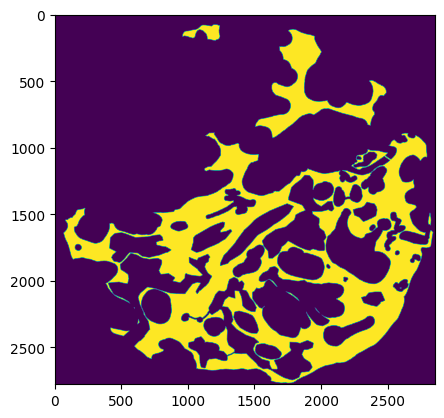

In [55]:
ann = section.annotations[0]
plt.imshow(ann.get_by_label('Lymphocyte_enriched_stroma'))

In [41]:
all_res['002_03']

{'ISUP1': 37,
 'Non-cancer glands': 72,
 'Lymphocyte-enriched stroma': 0,
 'Stroma': 43}

In [281]:
core_name = '002_03'
sections = load_sections(core_name)

In [282]:
st_section = sections['2']
msi_pos_section = sections['6']
msi_neg_section = sections['7']


In [229]:
spot_annotations_df[spot_annotations_df.core_name == '001_03'].unified_hp_class.unique()
# spot_annotations_df[(spot_annotations_df.core_name == '002_04') & (spot_annotations_df.unified_hp_class ==  'Non-cancer glands')]
# spot_annotations_df[spot_annotations_df.core_name == '047_02'].shape

array(['Stroma', 'Non-cancer glands'], dtype=object)

In [72]:
spot_annotations_df[spot_annotations_df.core_name == '001_03'].unified_hp_class.unique()

array(['Stroma', 'Non-cancer glands'], dtype=object)

002_01: Low normal glands, but seems to make sense now.
047_02: Many stroma spots in st, but not the others. Stroma missing
047_03: ISUP1 ISUP3 missing
047_01: Mismatch
046_03: Only tissue exported. Missing?!
004_04: No non-cancer glands in msi pos
004_02: Stroma missing
004_01: Missging lympho_stroma, but could be gone.
003_01: Stroma missing
002_03: Annotation wrongly warped. Tissue mask is wrong and lymphocyte_enriched_stroma seems to wrong as well. Use integrate_st_maldi_pos.ipynb to fix it.

TODO: Check that all annotations have the same label before and after registration
001_03 (A006, n): ST has only Normal Glands, and MSI_POS only ISUP. Does that make sense?
046_04: Only tissue exported. Missing?! No stroma in msi_neg (only lympho stroma, ask about that)

In [ ]:
from greedyfhist.utils.metrics import compute_tre

In [19]:
core_ids_to_paper_ids = {
    '001_04': 'P06_7',
    '002_01': 'P04_3',
    '003_02': 'P08_3',
    '004_03': 'P07_7',
    '045_03': 'P28_3',
    '047_04': 'P30_4',
    '048_02': 'P22_4'
}

acc_mp_dict = {}
acc_mn_dict = {}

for core_name in tqdm.tqdm(core_ids_to_paper_ids):
    sections = load_sections(core_name)
    st_section = sections['2']
    msi_pos_section = sections['6']
    msi_neg_section = sections['7']
    st_lms = st_section.landmarks.data
    msi_pos_lms = msi_pos_section.landmarks.data
    msi_neg_lms = msi_neg_section.landmarks.data
    st_mp_acc = compute_tre(st_lms, msi_pos_lms, st_section.image.data.shape)
    st_mn_acc = compute_tre(st_lms, msi_neg_lms, st_section.image.data.shape)
    acc_mp_dict[core_name] = st_mp_acc 
    acc_mn_dict[core_name] = st_mn_acc

100%|██████████| 7/7 [01:11<00:00, 10.18s/it]


In [25]:
acc_mn_df = pd.DataFrame(acc_mn_dict, index=['mean_rtre', 'median_rtre', 'mean_tre', 'median_tre']).transpose()[['mean_tre', 'median_tre']]
acc_mn_df.rename(index=core_ids_to_paper_ids)

,mean_tre,median_tre
P06_7,58.154485,48.601031
P04_3,92.775465,92.270969
P08_3,117.948073,113.688691
P07_7,152.253571,139.219941
P28_3,72.307415,68.269833
P30_4,104.391886,99.197226
P22_4,42.168853,38.082204


In [26]:
acc_mp_df = pd.DataFrame(acc_mp_dict, index=['mean_rtre', 'median_rtre', 'mean_tre', 'median_tre']).transpose()[['mean_tre', 'median_tre']]
acc_mp_df.rename(index=core_ids_to_paper_ids)

,mean_tre,median_tre
P06_7,57.711943,46.812632
P04_3,45.583013,38.863908
P08_3,100.050871,92.938995
P07_7,129.305662,123.176187
P28_3,47.820418,38.173251
P30_4,76.461377,69.462106
P22_4,32.413603,30.483259


In [16]:
mp_df = pd.DataFrame()
mn_df = 
for core_name in 

'004_02'

In [11]:
?compute_tre

Signature:
compute_tre(
    target_landmarks: pandas.core.frame.DataFrame,
    warped_landmarks: pandas.core.frame.DataFrame,
    target_shape: Tuple[int, int],
)
Docstring: <no docstring>
File:      /mnt/work/maximilw/miniconda3/envs/miit2/lib/python3.10/site-packages/greedyfhist/utils/metrics.py
Type:      function

In [12]:
st_lms = st_section.landmarks.data
msi_pos_lms = msi_pos_section.landmarks.data
msi_neg_lms = msi_neg_section.landmarks.data

(0.06091778607576546,
 0.06749671308866538,
 240.07742000392028,
 266.00501726897346)